# Neural Networks
### Made By Parth Agrawal 240905088 (Group-2)

In [66]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

### Data Processing

In [67]:
def load_images(path, img_size=(28, 28)):
    column_names = [f'pixel{i}' for i in range(1, img_size[0] * img_size[1] + 1)]
    column_names.append('label')
    images_df = pd.DataFrame(columns=column_names)

    for subpath in os.listdir(path):
        images = []
        full_path = os.path.join(path, subpath)
        for img in os.listdir(full_path):
            img_data = Image.open(os.path.join(full_path, img)).convert('L')  # Convert to grayscale
            img_data = img_data.resize(img_size)  # Resize to standard dimensions
            img_array = np.array(img_data).flatten() / 255.0  # Flatten and normalize
            images.append(img_array)
        
        subpath_df = pd.DataFrame(images, columns=column_names[:-1])
        subpath_df['label'] = subpath  # Assign folder name as label
        images_df = pd.concat([images_df, subpath_df], ignore_index=True)

    return images_df

# Load training and test data
train_set = load_images("Train")
test_set = load_images("Test")

# Extract features and labels
X_train_og = train_set.drop(columns='label')
y_train_og = train_set['label']

X_test_og = test_set.drop(columns='label')
y_test_og = test_set['label']

# Convert to NumPy arrays
X_train = np.array(X_train_og)
X_test = np.array(X_test_og)

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(np.array(y_train_og).reshape(-1, 1))
y_test = encoder.transform(np.array(y_test_og).reshape(-1, 1))

# Print dataset overview
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

# Verify data
train_set.head()

/tmp/ipykernel_5875/1910116327.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  images_df = pd.concat([images_df, subpath_df], ignore_index=True)


Training data shape: (4000, 784) (4000, 5)
Testing data shape: (1000, 784) (1000, 5)


/tmp/ipykernel_5875/1910116327.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  images_df = pd.concat([images_df, subpath_df], ignore_index=True)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane


In [68]:
# Define activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(X):
    e_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return e_X / np.sum(e_X, axis=1, keepdims=True)
# Compute loss (cross-entropy)
def compute_loss(y_true, y_pred, derivative=False):
    if derivative:
        return y_pred - y_true
    else:
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

In [69]:
# Define the Layer class
class Layer:
    def __init__(self, input_size, output_size, activation):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation
    
    def forward(self, input_data):
        self.input_data = input_data
        self.z = np.dot(input_data, self.weights) + self.bias
        if self.activation == 'relu':
            self.a = relu(self.z)
        elif self.activation == 'softmax':
            self.a = softmax(self.z)
        return self.a
    
    def backward(self, dA, alpha):
        if self.activation == 'relu':
            dZ = dA * relu_derivative(self.z)
        elif self.activation == 'softmax':
            dZ = dA
        
        m = self.input_data.shape[0]
        dW = np.dot(self.input_data.T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        
        self.weights -= alpha * dW
        self.bias -= alpha * db
        
        return np.dot(dZ, self.weights.T)

In [70]:
# Define the Neural Network class
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layers = []
        for i in range(1, len(layer_sizes)):
            activation = 'relu' if i < len(layer_sizes) - 1 else 'softmax'
            self.layers.append(Layer(layer_sizes[i-1], layer_sizes[i], activation))
    
    def forward(self, X):
        self.cache = []
        activation = X
        for layer in self.layers:
            activation = layer.forward(activation)
            self.cache.append(activation)
        return activation
    
    def backward(self, X, y_true, alpha):
        # compute loss gradient
        dA = compute_loss(y_true, self.cache[-1], derivative=True)
        for layer in reversed(self.layers):
            dA = layer.backward(dA, alpha)
    
    def train(self, X, y, epochs, alpha):
        losses = []
        for epoch in range(epochs):
            predictions = self.forward(X)
            loss = compute_loss(y, predictions)
            losses.append(loss)
            self.backward(X, y, alpha)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss}")
        return losses
    def predictions(self, values):
        # final predictions for the model
        return self.forward(values)

In [71]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot loss vs iterations
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss vs Iterations')
    plt.legend()
    plt.show()

# Compute and print evaluation metrics
def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

In [72]:
# Get input size
input_size = X_train.shape[1]
X_train

array([[0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.        ]])

Epoch 0/3001, Loss: 1.6095675998040107
Epoch 100/3001, Loss: 0.5696695668834735
Epoch 200/3001, Loss: 0.2709089417920476
Epoch 300/3001, Loss: 0.19299920102895624
Epoch 400/3001, Loss: 0.15867087270363905
Epoch 500/3001, Loss: 0.13977725858270265
Epoch 600/3001, Loss: 0.12771632897075816
Epoch 700/3001, Loss: 0.1190234338926457
Epoch 800/3001, Loss: 0.11211162180186014
Epoch 900/3001, Loss: 0.10628593318361579
Epoch 1000/3001, Loss: 0.10124422281381952
Epoch 1100/3001, Loss: 0.09672514347034249
Epoch 1200/3001, Loss: 0.09261194915148728
Epoch 1300/3001, Loss: 0.08881652635597041
Epoch 1400/3001, Loss: 0.08527497148218949
Epoch 1500/3001, Loss: 0.08196006467266227
Epoch 1600/3001, Loss: 0.07887058215310871
Epoch 1700/3001, Loss: 0.07597154231108022
Epoch 1800/3001, Loss: 0.07325096448638765
Epoch 1900/3001, Loss: 0.0706961470444252
Epoch 2000/3001, Loss: 0.06829388466776497
Epoch 2100/3001, Loss: 0.06602966551387837
Epoch 2200/3001, Loss: 0.06389785548681619
Epoch 2300/3001, Loss: 0.061

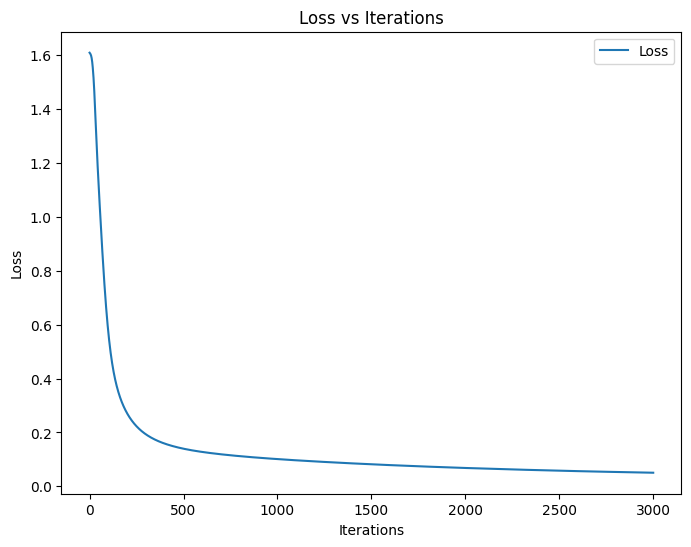

In [73]:
layer_sizes = [28*28, 70, len(categories)]  # Input size, hidden layer, output size
nn = NeuralNetwork(layer_sizes)

epochs = 3001  # Adjust as needed
alpha = 0.1325   # Learning rate
losses = nn.train(X_train, y_train, epochs, alpha)

# Plot loss graph
plot_loss(losses)


Accuracy: 0.9540
Precision: 0.9541
Recall: 0.9540
F1-score: 0.9540


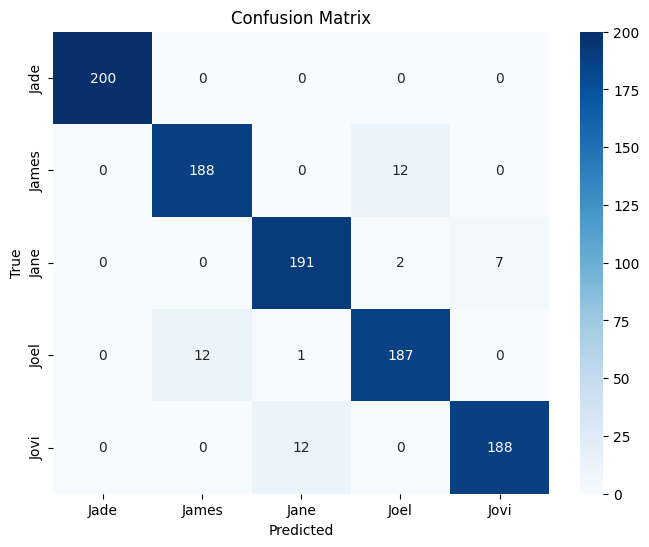

In [74]:
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = y_pred

# Compute and print evaluation metrics
print_metrics(y_true_labels, y_pred_labels)

# Plot confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels, categories)
